# Page Object Model for operability

One of the core feature of Manen is its implementation of the Page Object Model design pattern, which provides an interface between the core methods of Selenium's WebDriver, and the workflows of your application. By using this design pattern, you shouldn't have to re-implement fucntions to access DOM elements; you just have to desccribe your page structure by breaking it into multiple components. This will help to increase the readability and operability of your code.

This step-by-step guide shows how to use Manen for such purposes. We will use PyPI web page as playground for the exploration.

---

First, we need a WebDriver instance that will be the entrypoint for all our code. We will also define an helper function in charge of taking a screenshot of the current page, and display it inline.

In [1]:
from tempfile import NamedTemporaryFile

from IPython.display import Image, display
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.webdriver import WebDriver
from selenium.webdriver.common.selenium_manager import SeleniumManager

In [2]:
def screenshot(driver: WebDriver):
    with NamedTemporaryFile(suffix='.png') as f:
        driver.save_screenshot(f.name)
        display(Image(f.name))

In [3]:
selenium_manager = SeleniumManager()
paths = selenium_manager.binary_paths(["--browser", "chrome"])

service = Service(executable_path=paths["driver_path"])
options = Options()
options.add_argument("--window-size=1024,768")
driver = WebDriver(service=service)

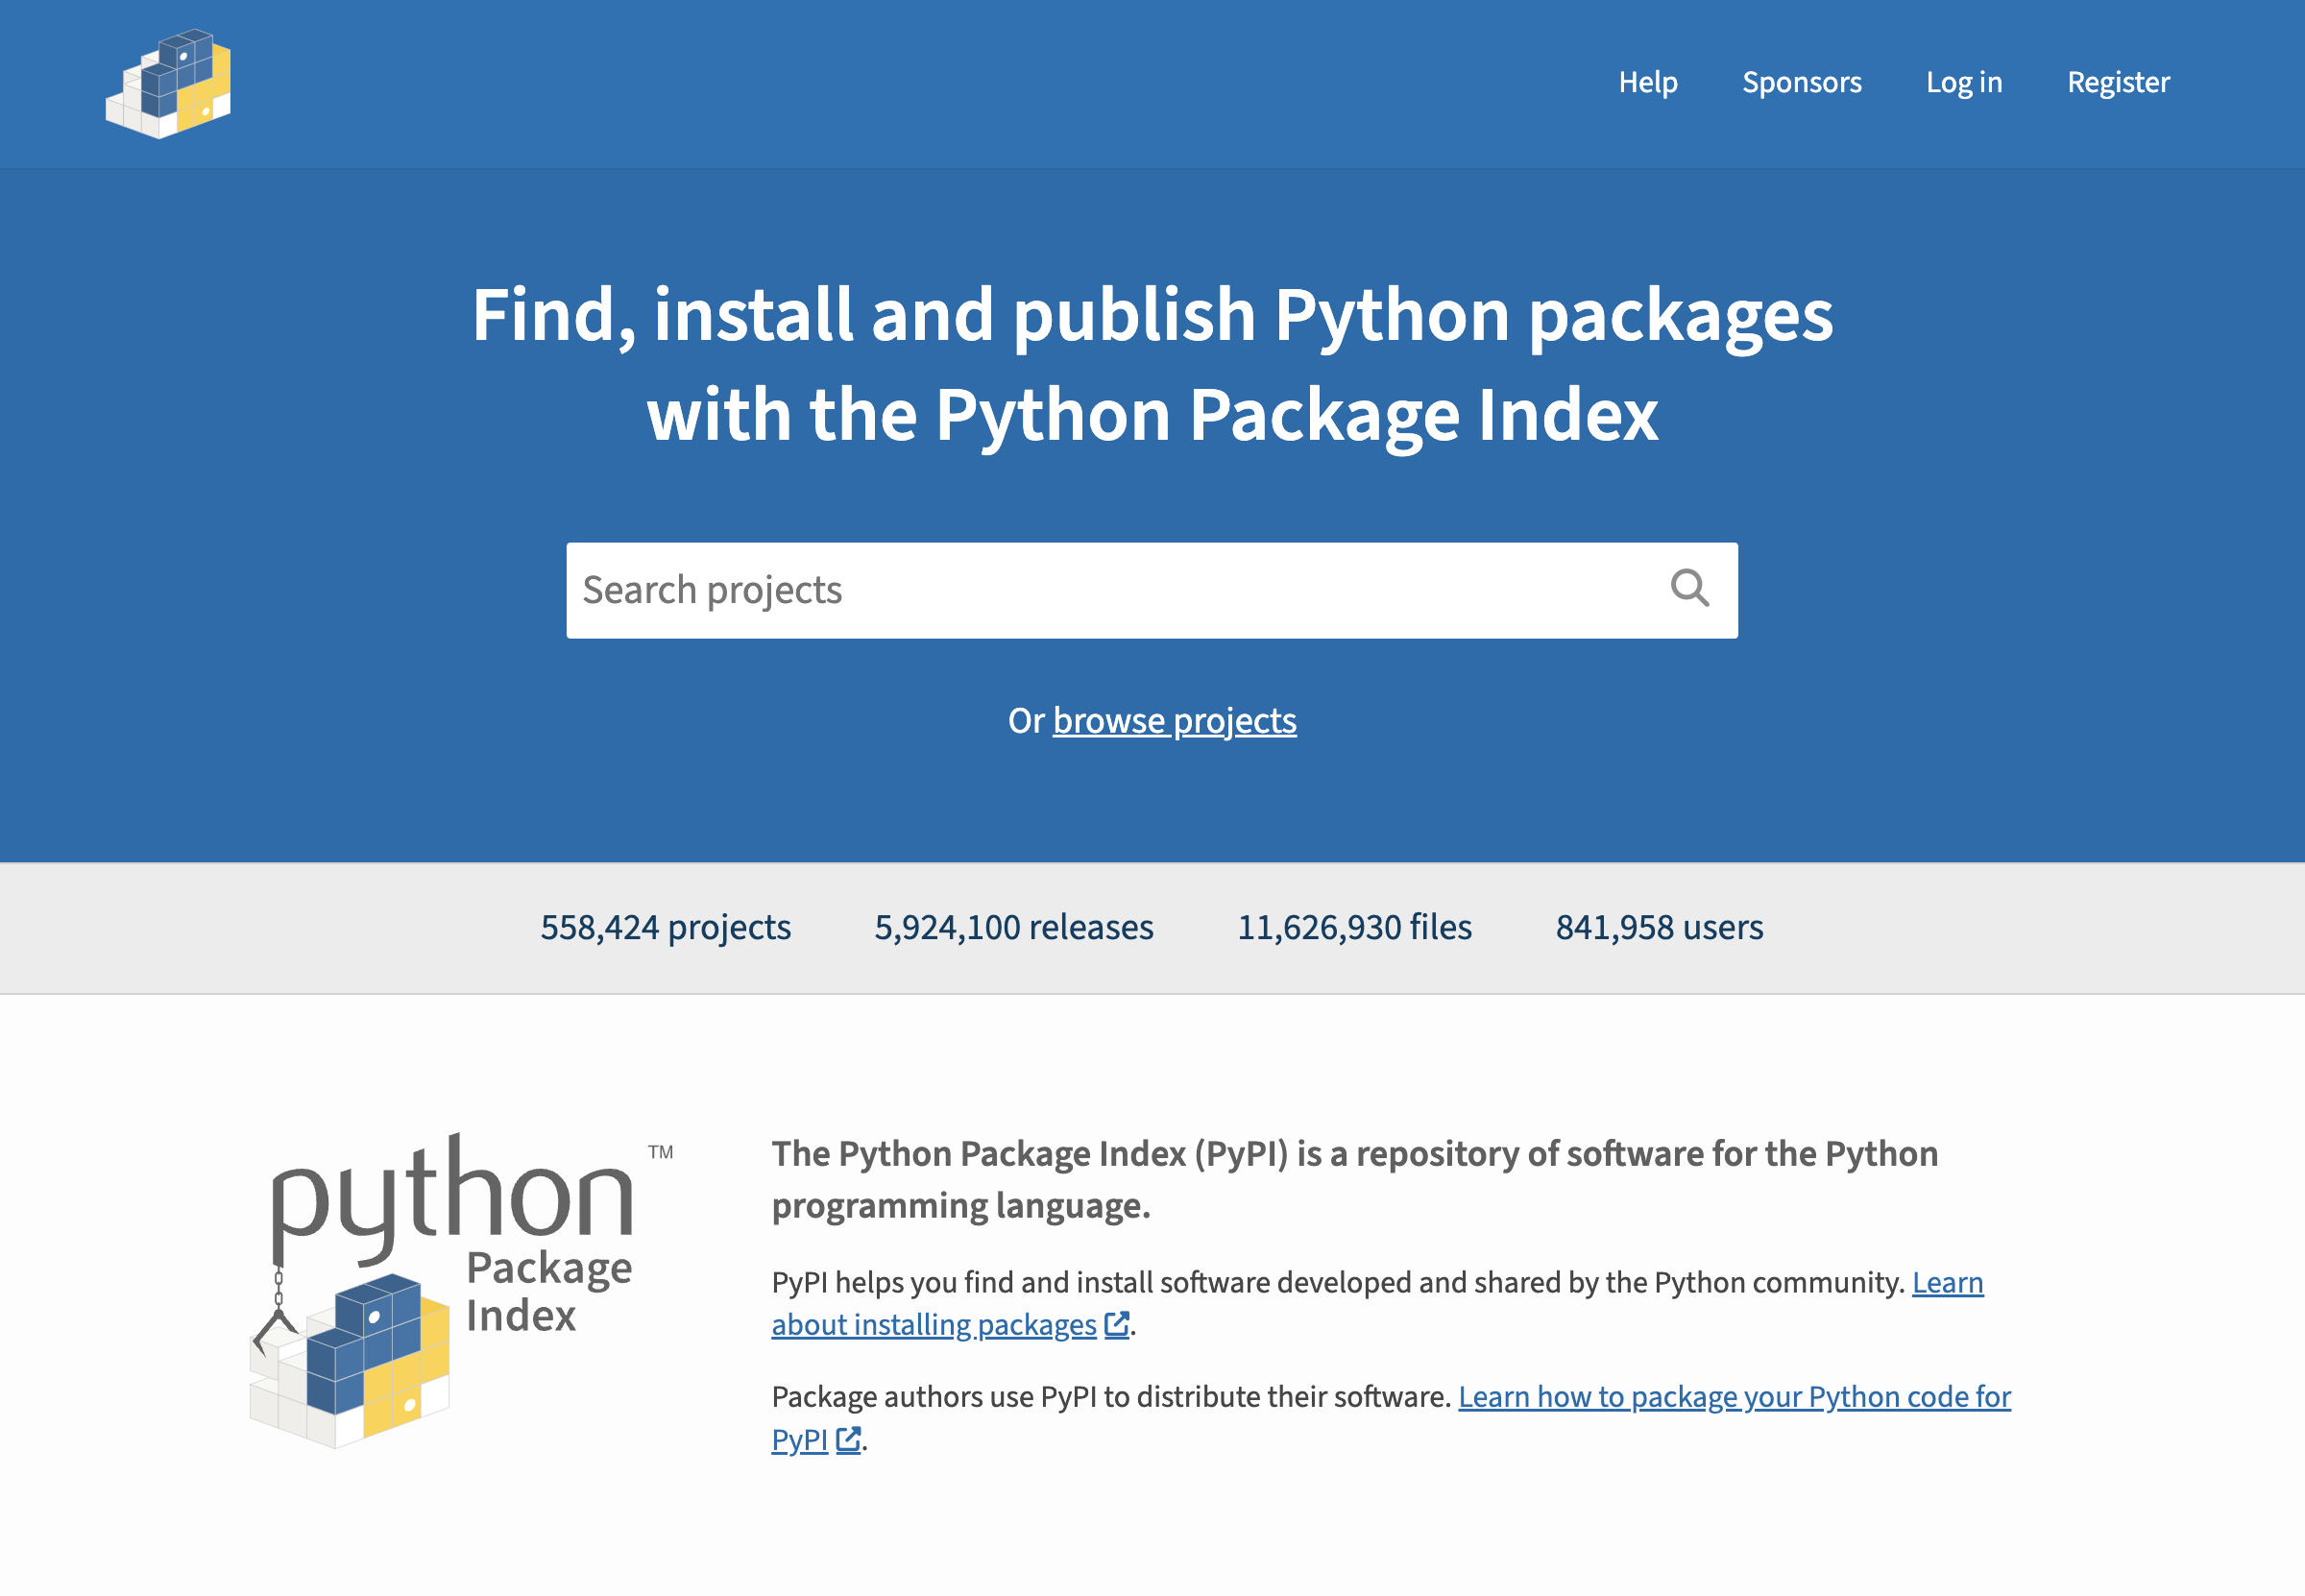

In [4]:
driver.get('https://pypi.org')

# Switch to the english page for results consistency
driver.add_cookie({'name': '_LOCALE_', 'value': 'en'})
driver.refresh()

screenshot(driver)

## DOM interactions

The main idea behind the page object model is to use simple Pythonic code to interact with your page. Python classes, as long as types annotations, will be use to describe our page. Each class will inherit from a Manen webarea, in order to symbolize the fact that they should be related to the DOM of the current page.

Each class attributes must be annotated with the type of element you want to retrieve, as long as the selectors to use to locate the elements. Manen provides some types to represent basic DOM elements; you can also use the type `str` (to extract the inner text of an element), `int` or `datetime` to attempt to convert the text to the associated types. Note that you can use `dom.WebElement` to return the raw Selenium web element.

In [5]:
from typing import Annotated

from manen.page_object_model import dom
from manen.page_object_model.config import CSS, XPath
from manen.page_object_model.webarea import Form, Page, WebArea


class NavigationBar(WebArea):
    class NavigationMenuItem(WebArea):
        label: Annotated[str, CSS("a.horizontal-menu__link")]
        link: Annotated[dom.HRef, CSS("a.horizontal-menu__link")]

    logo: Annotated[dom.ImageSrc, CSS("a.site-header__logo img")]
    items: Annotated[list[NavigationMenuItem], CSS("ul li.horizontal-menu__item")]


class PyPIHomePage(Page):
    class SearchForm(Form):
        query: Annotated[dom.Input, CSS("input[name='q']")]

    navbar: Annotated[NavigationBar, CSS("header.site-header")]
    search: Annotated[SearchForm, CSS("form.search-form")]

A page should be initialized using the driver instance.

In [6]:
page = PyPIHomePage(driver)

You can now access each one of your element as attributes of the page you created.

In [7]:
print(page.navbar.logo)

https://pypi.org/static/images/logo-small.8998e9d1.svg


Each WebArea provides a method `model_dump` to serialize all the attributes into a dictionary.

In [8]:
page.navbar.model_dump()

{'logo': 'https://pypi.org/static/images/logo-small.8998e9d1.svg',
 'items': [{'label': 'Help', 'link': 'https://pypi.org/help/'},
  {'label': 'Sponsors', 'link': 'https://pypi.org/sponsors/'},
  {'label': 'Log in', 'link': 'https://pypi.org/account/login/'},
  {'label': 'Register', 'link': 'https://pypi.org/account/register/'}]}

Filling the value of the input with the search query is as simple as doing a variable attribution.

In [9]:
page.search.query = "selenium"

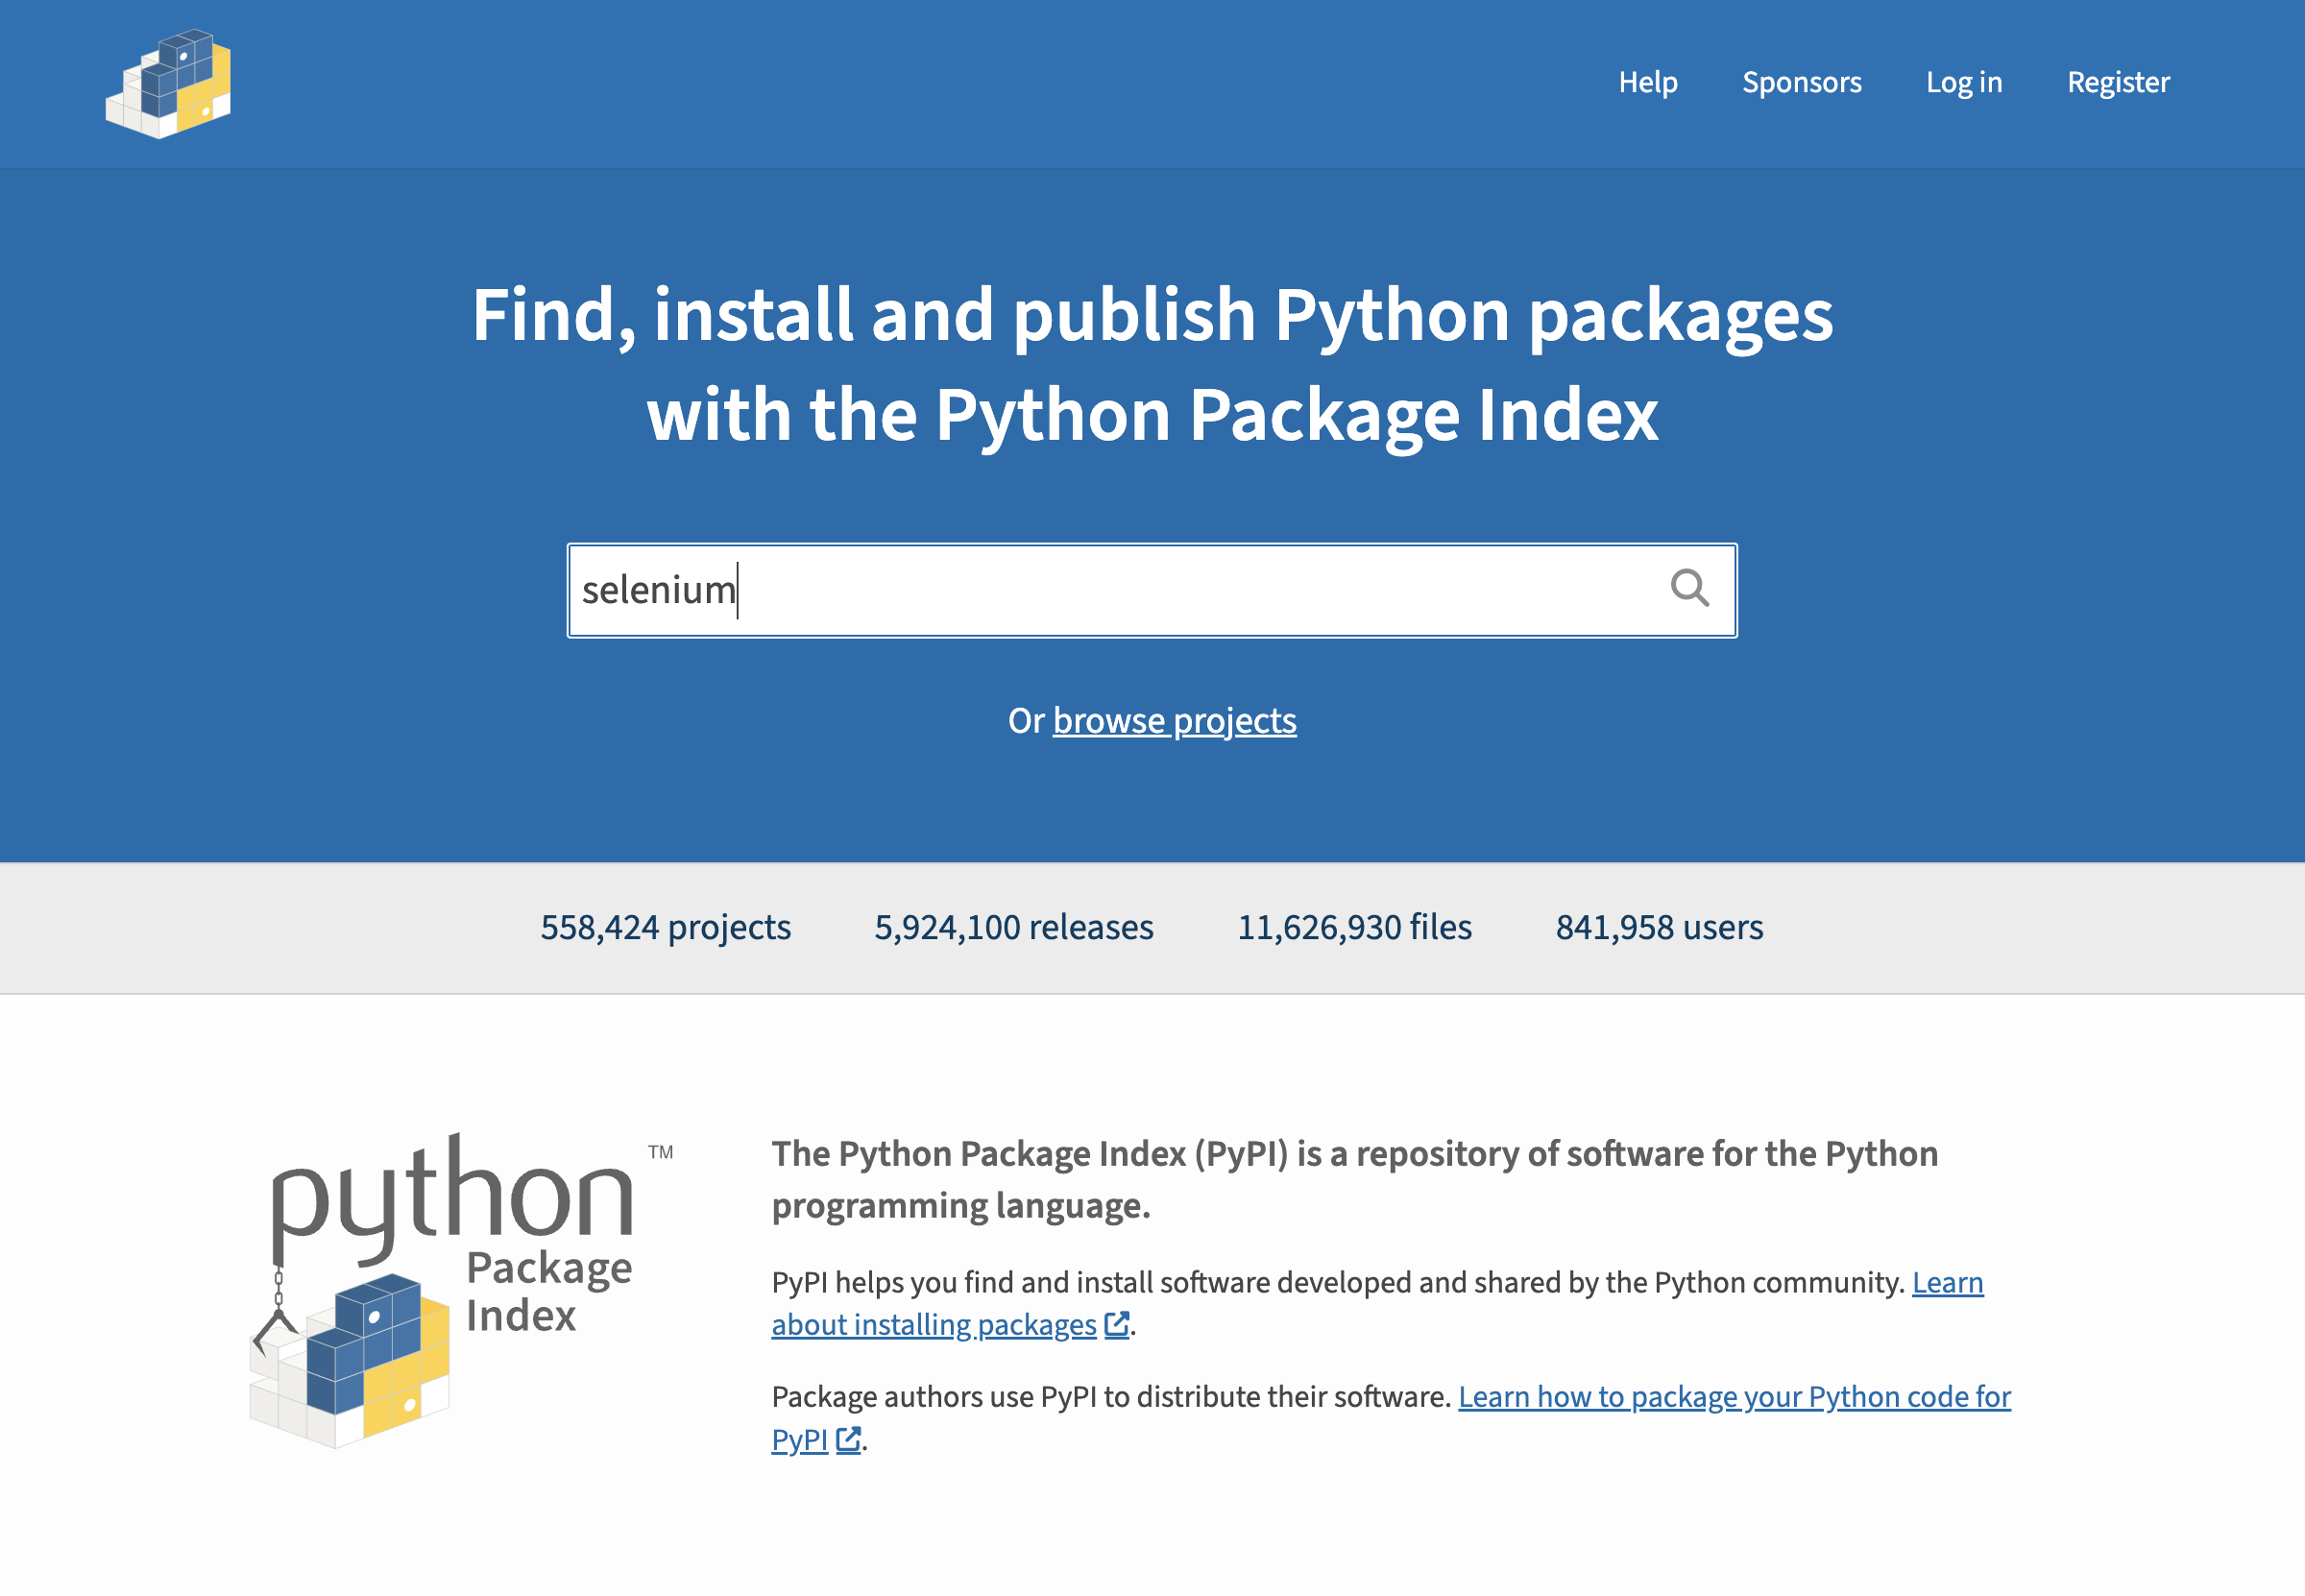

In [10]:
screenshot(driver)

Given that `page.search` inherit from the `Form` class, it has a method `submit` you can call to submit the query. Note that it can also be done with the following script: 

```python
from selenium.webdriver.common.keys import Keys

page.search.query += Keys.ENTER
```

In [11]:
page.search.submit()

By doing so, we navigated to another page, with the results of the search.

Current URL: https://pypi.org/search/?q=selenium


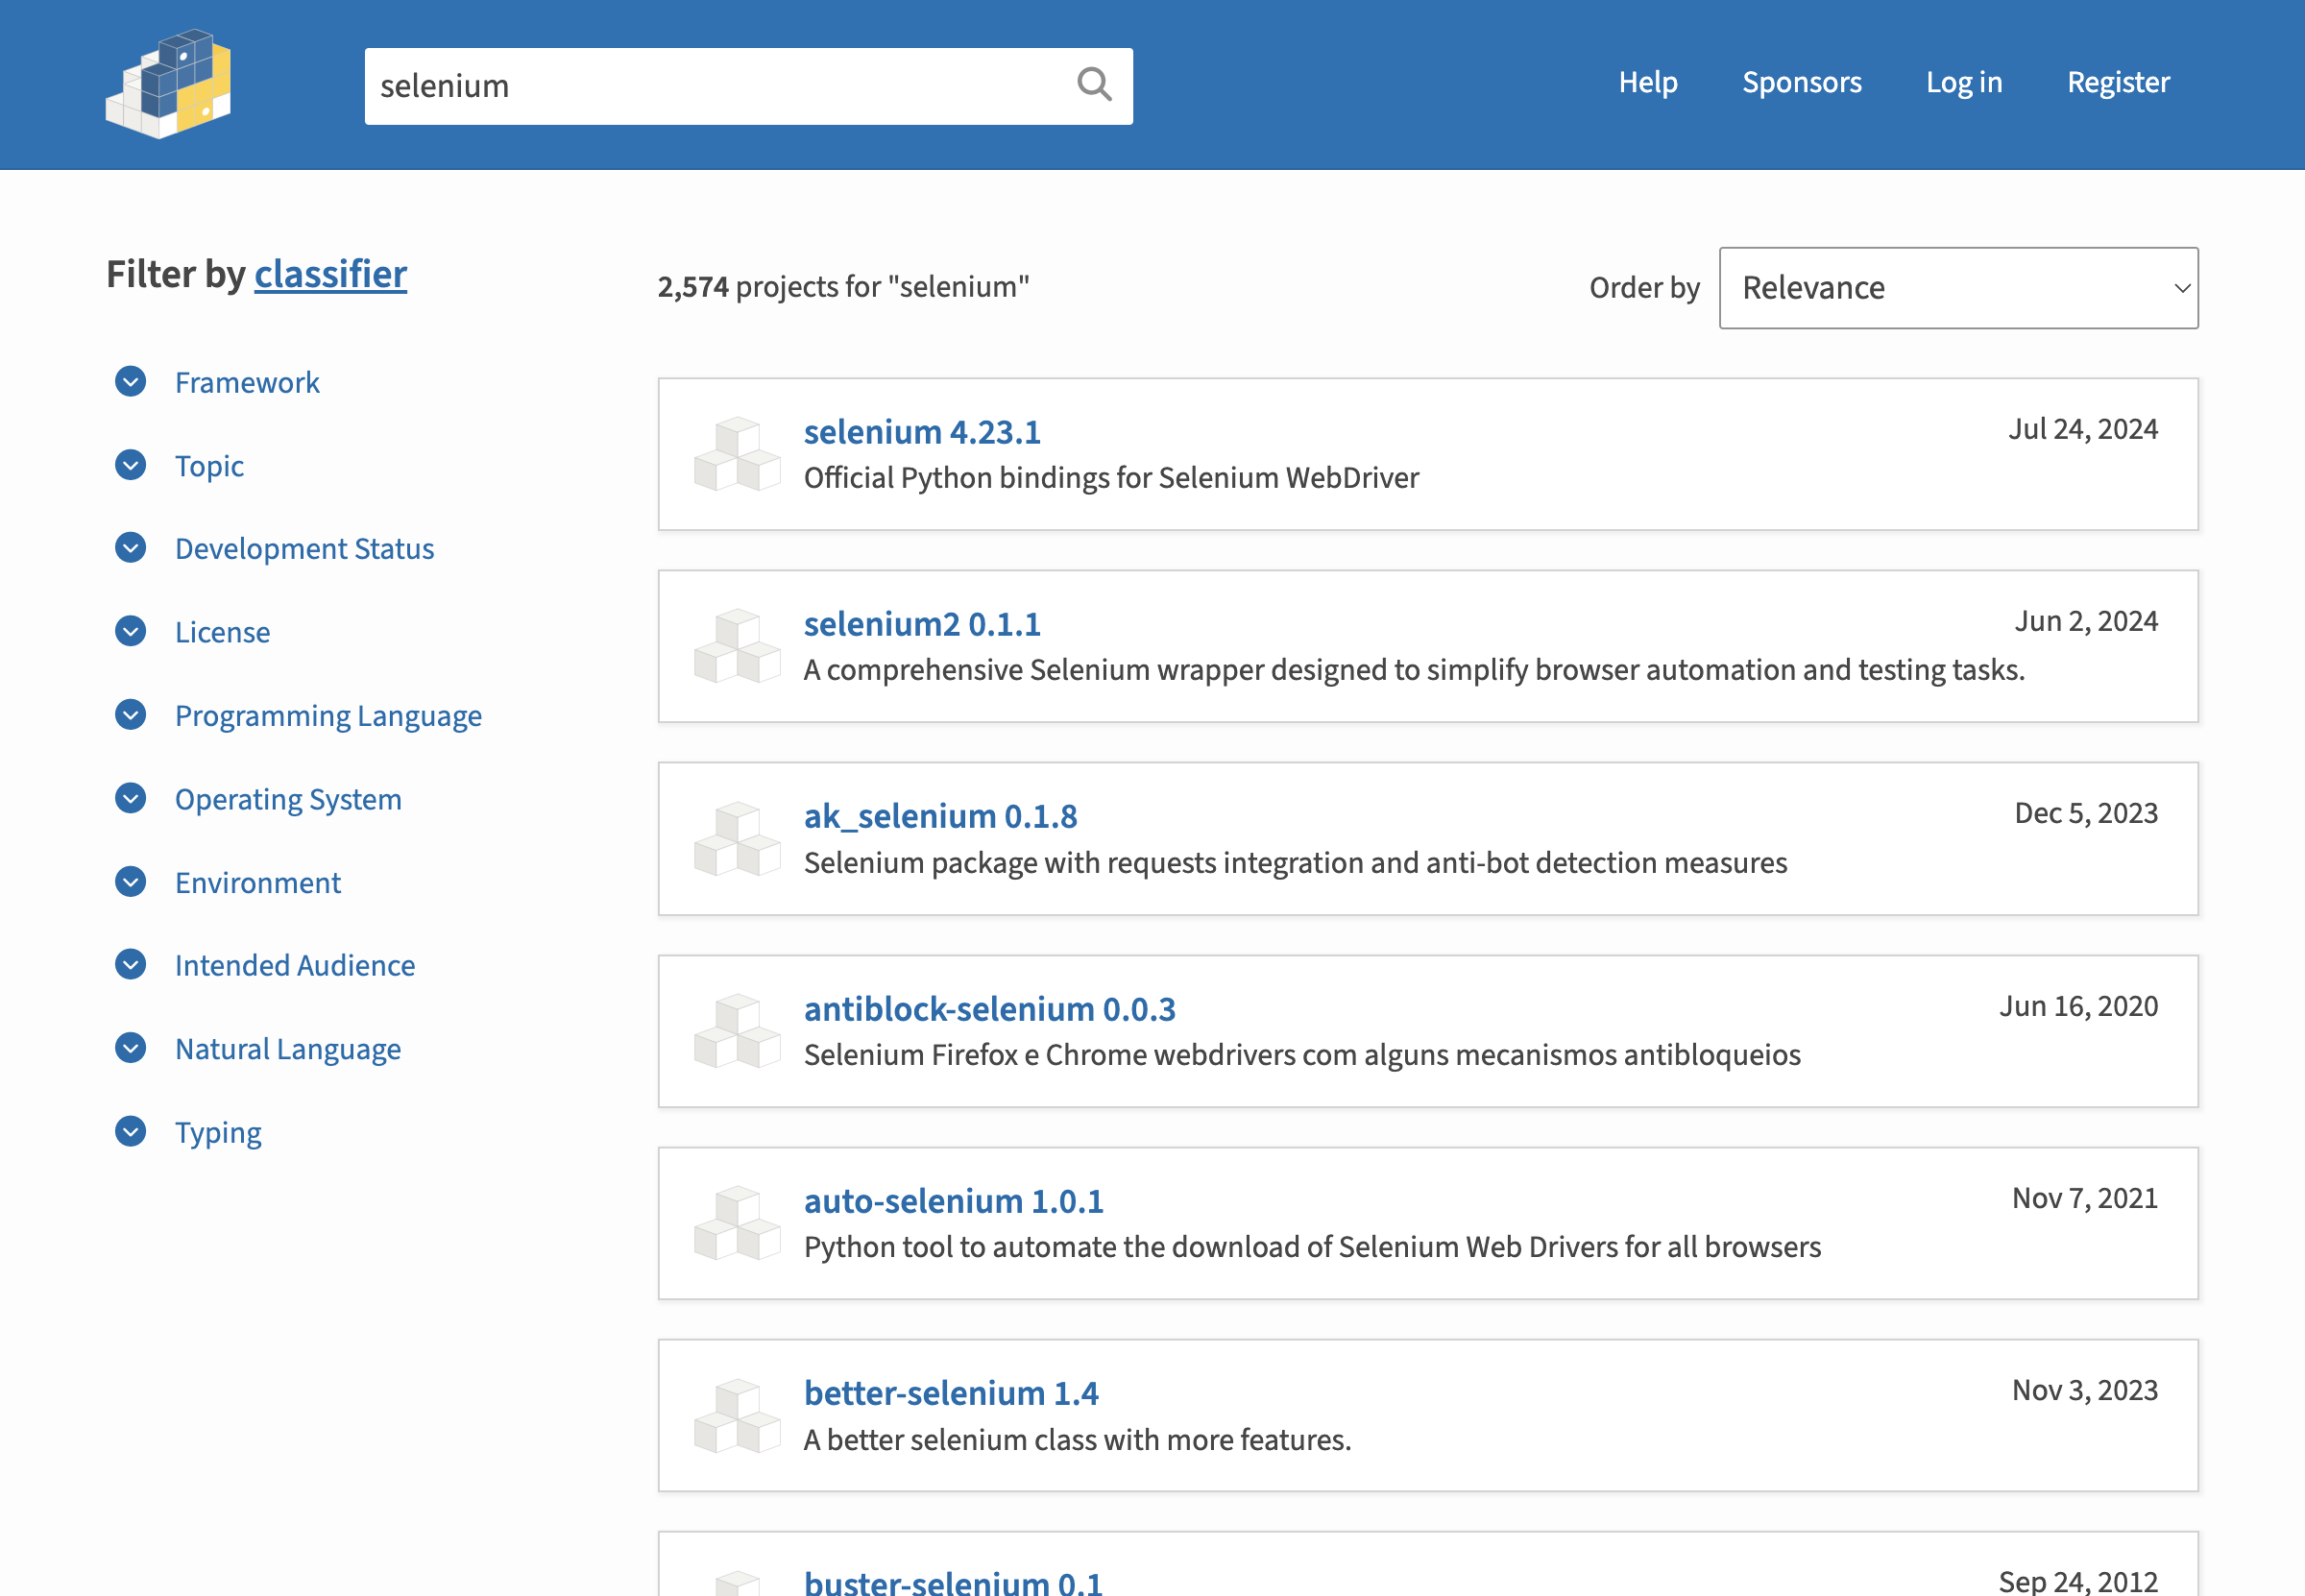

In [12]:
print('Current URL:', driver.current_url)
screenshot(driver)

Let's define another page to describe the current structure. Notice that we re-use the class `NavigationBar` given that this web component is also on the current page.

In [13]:
from datetime import datetime, timedelta


class SearchResultPage(Page):
    class Result(WebArea):
        name: Annotated[str, CSS("h3 span.package-snippet__name")]
        version: Annotated[str, CSS("h3 span.package-snippet__version")]
        link: Annotated[dom.HRef, CSS("a.package-snippet")]
        description: Annotated[str, CSS("p.package-snippet__description")]
        release_date: Annotated[datetime, CSS("span.package-snippet__created")]

        @property
        def is_recent(self):
            return self.release_date >= datetime.now() - timedelta(days=180)

        def print_summary(self):
            summary = f"{self.name} (v{self.version}) has been released on {self.release_date.date()}"
            if self.is_recent:
                summary += ", less than 180 days ago"
            print(summary)

    navbar: Annotated[NavigationBar, CSS("header.site-header")]

    nb_results: Annotated[
        int,
        XPath("//*[@id='content']//form/div[1]/div[1]/p/strong"),
    ]
    results: Annotated[
        list[Result],
        CSS("ul[aria-label='Search results'] li"),
    ]

In [14]:
page = SearchResultPage(driver)

In [15]:
print("Number of results for the query:", page.nb_results)
print("Number of results on the page:", len(page.results))

Number of results for the query: 2574
Number of results on the page: 20


Same as before, we can access the elemens of the navigation bar.

In [16]:
page.navbar.model_dump()

{'logo': 'https://pypi.org/static/images/logo-small.8998e9d1.svg',
 'items': [{'label': 'Help', 'link': 'https://pypi.org/help/'},
  {'label': 'Sponsors', 'link': 'https://pypi.org/sponsors/'},
  {'label': 'Log in', 'link': 'https://pypi.org/account/login/'},
  {'label': 'Register', 'link': 'https://pypi.org/account/register/'}]}

Besides, all the search results of the page will be on each item of `page.results`.

In [17]:
page.results[0].model_dump()

{'name': 'selenium',
 'version': '4.23.1',
 'link': 'https://pypi.org/project/selenium/',
 'description': 'Official Python bindings for Selenium WebDriver',
 'release_date': datetime.datetime(2024, 7, 24, 0, 0)}

> Note that `model_dump` doesn't include custom properties in the dictionary.

We can then call the custom method `print_summary` we implemented for `Result` item.

In [18]:
for result in page.results[:5]:
    result.print_summary()

selenium (v4.23.1) has been released on 2024-07-24, less than 180 days ago
selenium2 (v0.1.1) has been released on 2024-06-02, less than 180 days ago
ak_selenium (v0.1.8) has been released on 2023-12-05
antiblock-selenium (v0.0.3) has been released on 2020-06-16
auto-selenium (v1.0.1) has been released on 2021-11-07


## List of available elements

Manen implements out of the box the current elements:

| Element      | Description                                                      |
|--------------|------------------------------------------------------------------|
| `HRef`       | Extract the link of a <a> tag                                    |
| `ImageSrc`   | Extract the `src` attribute of an `<img>`                        |
| `InnerHTML`  | Extract the inner HTML of an element                             |
| `OuterHTML`  | Extract the outer HTML of an element                             |
| `Input`      | Form element to interact with an input element                   |
| `WebElement` | Return the raw Selenium element                                  |
| `str`        | Extract the inner text of an element                             |
| `int`        | Extract an integer from inner text of an element                 |
| `datetime`   | Extract the inner text of an element, and parse it to a datetime |


> The list of elements provided by Manen intends to grow to cover a maximum of use cases.

## Advanced usage

The page object implementation is using internally the `find` function, which has additional arguments to customize how to retrieve elements from the DOM (see associated user guide for more details about that). In the same way, you can add options to each attribute of your class to enable this level of customization in your model.

For example, let's say the element with the number of results dynamically arrives after the page is loaded. We can wait for this element to appear. For elements that can be absent from the DOM, we can add a default value.

In [19]:
from manen.page_object_model.config import Default, Wait

class SearchResultPage(Page):
    nb_results: Annotated[
        int,
        XPath("//*[@id='content']//form/div[1]/div[1]/p/strong"),
        Wait(5),
    ]

    dont_exist: Annotated[str | None, CSS('i-dont-exist'), Default(None)]

page = SearchResultPage(driver)

In [20]:
assert page.dont_exist is None

Note that when using a default value, the type specified in the annotation should be coherent with the default value, with the restriction that only not-None type is allowed. For example, you can't have something like `Annotated[int | str, CSS('i-dont-exist'), Default('not here')]`.

---

You are now familiar with the page object model implementation of Manen! Don't hesitate to [open an issue](https://github.com/kodaho/manen/issues) if you have any remarks, concerns, or feature request!

In [21]:
driver.quit()